<div class="alert alert-block alert-success" align = center>
    <h1>k-NEAREST NEIGHBOR</h1>
</div>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score

In [2]:
def split(dataframe):
    
    # Si toglie la colonna da predire
    X = dataframe.drop(columns=['Sale_Price'], axis =1)

    # Si isola la colonna da predire
    y = dataframe['Sale_Price']

    X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, test_size = 0.20, random_state = 3)
    
    return X_train_80, X_test, y_train_80, y_test

In [3]:
def divide(dataframe):
    
    # Si separano le feature dal prezzo
    X_train = dataframe.drop(columns = ['Sale_Price'], axis = 1)
    
    y_train = dataframe['Sale_Price']
    
    return X_train, y_train

Si importa il dataset sporco con outliers.

In [4]:
df = pd.read_csv('dataset_enc.csv')

In [5]:
X_train_80, X_test, y_train_80, y_test = split(df)

Si importano il training-set e il test-set del dataset sporco ma senza outliers.

In [6]:
df_train_wo_out = pd.read_csv('training_wo_outliers.csv')

In [7]:
X_train_wo_out, y_train_wo_out = divide(df_train_wo_out)

Si importa il training-set pulito con outliers su cui è stata applicata la tecnica dell'RFECV con gli outliers.

In [8]:
df_clean_train = pd.read_csv('df_train_RFECV.csv')

In [9]:
X_clean_train_80, y_clean_train_80 = divide(df_clean_train)

Si importa il training-set pulito ma senza outliers su cui è stata applicata RFECV.

In [10]:
df_clean_train_wo_out = pd.read_csv('df_train_wo_out_RFECV.csv')

In [11]:
X_clean_train_wo_out, y_clean_train_wo_out = divide(df_clean_train_wo_out)

E infine il test-set pulito su cui è stata applicata RFECV.

In [12]:
df_clean_test = pd.read_csv('df_test_RFECV.csv')

In [13]:
X_clean_test, y_clean_test = divide(df_clean_test)

### Funzione che implementa il k-NN base

In [14]:
def kNN_base(X_train, X_test, y_train, y_test):
    
    # Array per salvarsi i risultati ottenuti
    MAE = []
    
    # Creazione del modello
    model = KNeighborsRegressor(n_neighbors = 3)
    model.fit(X_train, y_train)
    
    # Calcolo dell'mae assoluto per il test-set
    y_pred_test = model.predict(X_test)
    MAE = mean_absolute_error(y_true = y_test, y_pred = y_pred_test)
    
    # Grafico y reali vs y predette
    plt.scatter(y_test, y_pred_test)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # Calcolo dello score
    score = r2_score(y_test, y_pred_test)

    return MAE, score

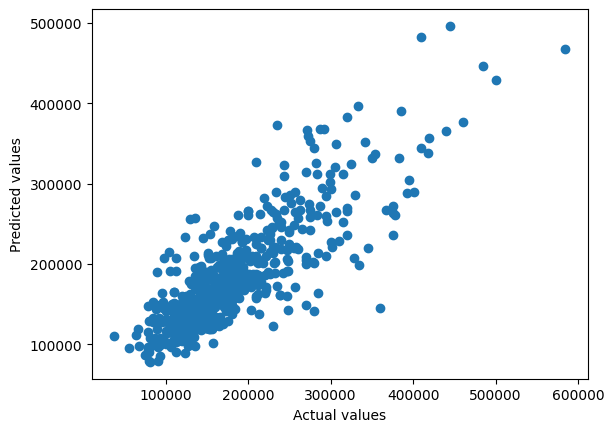

In [15]:
MAE_test_base, score = kNN_base(X_train_80, X_test, y_train_80, y_test)

In [16]:
print("Errore: ", MAE_test_base)
print("Score: ", score)

Errore:  30041.784414106944
Score:  0.68591408915801


Qui di seguito si prova il modello base anche sugli altri dataframe.

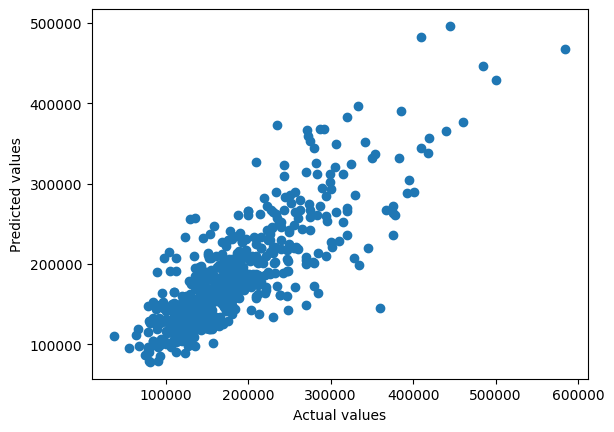

In [17]:
MAE_test_base_wo_out, score_wo_out = kNN_base(X_train_wo_out, X_test, y_train_wo_out, y_test)

In [18]:
print("Errore: ", MAE_test_base_wo_out)
print("Score: ", score_wo_out)

Errore:  30046.44880546075
Score:  0.688005940924971


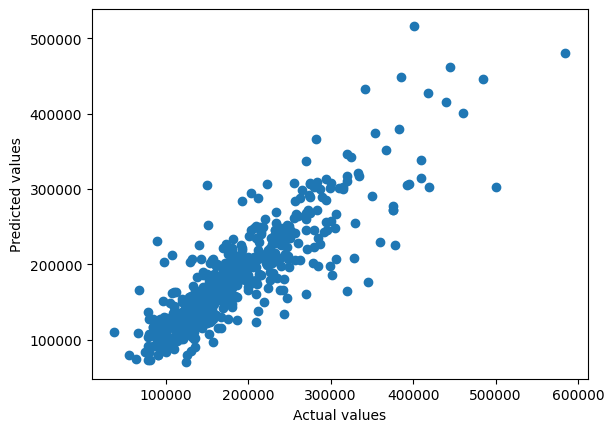

In [19]:
MAE_test_clean_base, score_clean = kNN_base(X_clean_train_80, X_clean_test, y_clean_train_80, y_clean_test)

In [20]:
print("Errore: ", MAE_test_clean_base)
print("Score: ", score_clean)

Errore:  24530.246871444822
Score:  0.7522665536980097


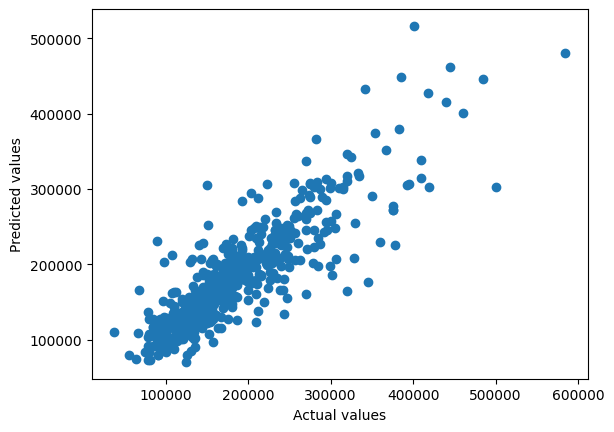

In [21]:
MAE_test_clean_base_wo_out, score_clean_wo_out = kNN_base(X_clean_train_wo_out, X_clean_test, y_clean_train_wo_out, y_clean_test)

In [22]:
print("Errore: ", MAE_test_clean_base_wo_out)
print("Score: ", score_clean_wo_out)

Errore:  24637.030147895333
Score:  0.750011411010182


<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

Per queste considerazioni si sta facendo riferimento ad un modello che ha il paramentro k= 3.

Si noti come la rimozione degli outliers funzioni meglio nel caso del dataset iniziale mentre nel dataset pulito essa porti a un lieve peggioramento delle predizioni (0.002%).

Si vede anche come la pulizia ha portato ad un miglioramento nelle predizioni le quali ora portano lo score a superare la soglia del 75%, quando prima si aggiravano intorno al 68%.

> Split per Cross-Validation

Si dividono i training-set per poter effettuare Cross-Validation

In [23]:
def split_cross(X_train, y_train):
    
    X_train_new, X_valid, y_train_new, y_valid  = train_test_split(X_train, y_train, test_size = 0.25, random_state = 3)
    
    return X_train_new, X_valid, y_train_new, y_valid

In [24]:
X_train_v_80, X_valid, y_train_v_80, y_valid = split_cross(X_train_80, y_train_80)

In [25]:
X_train_v_wo_out, X_valid_wo_out, y_train_v_wo_out, y_valid_wo_out = split_cross(X_train_wo_out, y_train_wo_out)

In [26]:
X_clean_train_v_80, X_clean_valid, y_clean_train_v_80, y_clean_valid = split_cross(X_clean_train_80, y_clean_train_80)

In [27]:
X_clean_train_v_wo_out, X_clean_valid_wo_out, y_clean_train_v_wo_out, y_clean_valid_wo_out = split_cross(X_clean_train_wo_out, y_clean_train_wo_out)

### Funzione che implementa la ricerca del miglior valore per k 

#### Ricerca della miglior k con cross validation 

In [28]:
def cv_knn(X_train, X_valid, X_test, y_train, y_valid, y_test, n_neighbors = 3):
    
    # Array per salvarsi i risultati ottenuti
    MAE = []
    MAE_plot = []
    
    # ------------------------------------------------------------------
    
    # Ciclo for per vedere i cambiamenti dell'mae in base al numero di vicini considerati
    for i in range(1, n_neighbors):
        
        # Creazione modello
        model =  KNeighborsRegressor(n_neighbors = i)
        model.fit(X_train, y_train)
        
        # Calcolo dell'errore (mae) sul training-set
        y_pred_train = model.predict(X_train)
        MAE_train = mean_absolute_error(y_true = y_train, y_pred = y_pred_train)
        
        # Calcolo dell'errore (mae) sul valid-set
        y_pred_valid = model.predict(X_valid)
        MAE_valid = mean_absolute_error(y_true = y_valid, y_pred = y_pred_valid)
        
        # L'array mae contiene elementi che a loro volta sono array di 3 elementi: 
        # parametro di regolarizzazione, errore sul train e errore sul valid
        MAE_plot += [[i, MAE_train, MAE_valid]]
        
    # ------------------------------------------------------------------
    
    # Si cerca l'errore migliore (il più piccolo)
    minimum_error = MAE_plot[0][2]
    best_n_neigh = MAE_plot[0][0]
    
    for i in range(len(MAE_plot)):
        if(minimum_error > MAE_plot[i][2]):
            minimum_error = MAE_plot[i][2]
            best_n_neigh = MAE_plot[i][0]

    # Si crea un nuovo modello con il parametro di regolarizzazione associato all'errore migliore
    best_model = KNeighborsRegressor(n_neighbors = best_n_neigh)
    best_model.fit(X_train, y_train)
    
    # Calcolo dell'errore assoluto sul test-set
    y_pred_test = best_model.predict(X_test)
    MAE_test = mean_absolute_error(y_true = y_test, y_pred = y_pred_test)
    
    # L'array best_n_estimators contiene elementi che a loro volta sono array di 2 elementi: 
    # numero di vicini, errore assoluto sul test
    MAE = [best_n_neigh, MAE_test]

    MAE_plot = np.array(MAE_plot)
    
    # Grafico y reali vs y predette
    plt.scatter(y_test, y_pred_test)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # Grafico
    fig, ax = plt.subplots()
    ax.plot(MAE_plot[:,0], MAE_plot[:,1], "x:", label = "Train")
    ax.plot(MAE_plot[:,0], MAE_plot[:,2], "s-", label = "Valid")
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    ax.legend()
    ax.grid()
    
    # Calcolo dello score
    score = r2_score(y_test, y_pred_test)
    
    #dataframe per il confronto finale dei prezzi predetti
    dataframe_diff = pd.DataFrame({'Actual Value' : y_test, 'Predicted Value' : y_pred_test, 'Difference' : abs(y_test - y_pred_test)})
    
    return MAE, score, dataframe_diff

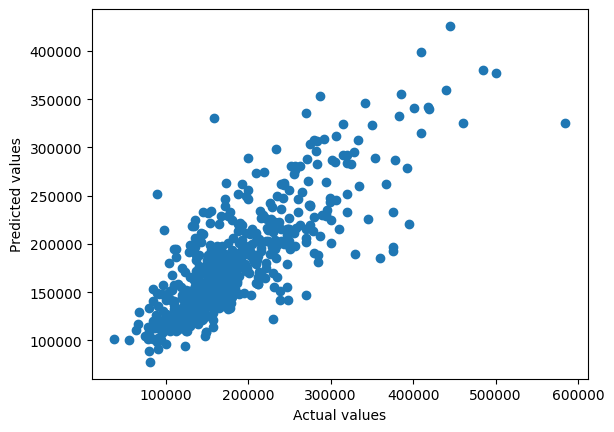

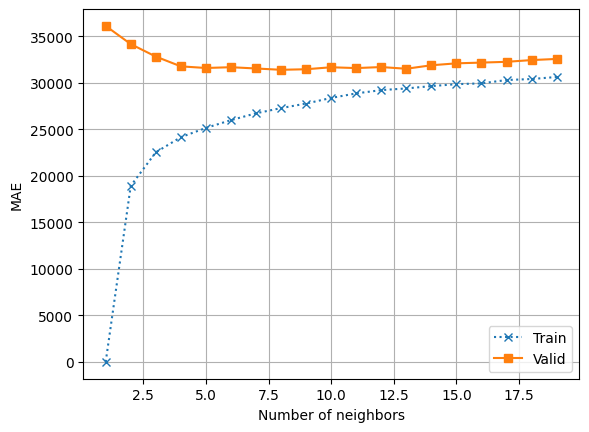

In [29]:
MAE_test, score, dataframe_diff = cv_knn(X_train_v_80, X_valid, X_test, y_train_v_80, y_valid, y_test, 20)

In [30]:
print("Il miglior valore di k è: ", MAE_test[0])
print("Errore: ", MAE_test[1])
print("Score: ", score)

Il miglior valore di k è:  8
Errore:  29994.893558020478
Score:  0.661182123747055


Ora si valuta il cross-validation anche sugli altri dataframe.

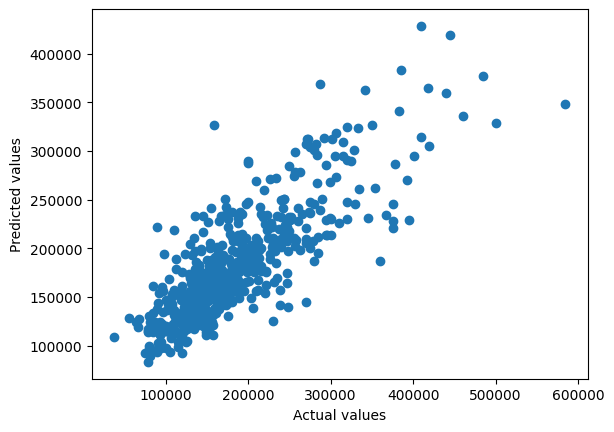

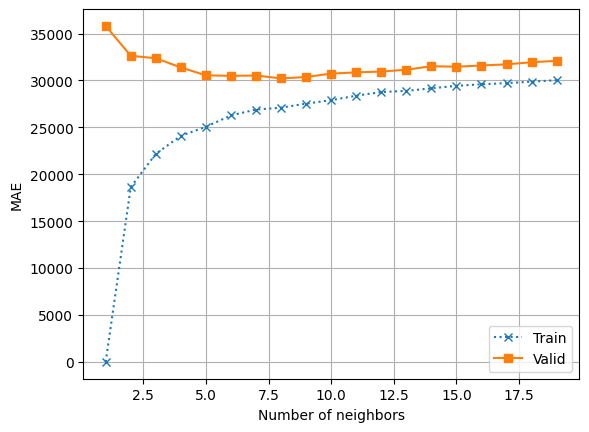

In [31]:
MAE_test_wo_out, score_wo_out, dataframe_diff = cv_knn(X_train_v_wo_out, X_valid_wo_out, X_test, y_train_v_wo_out, y_valid_wo_out, y_test, 20)

In [32]:
print("Il miglior valore di k è: ", MAE_test_wo_out[0])
print("Errore: ", MAE_test_wo_out[1])
print("Score: ", score)

Il miglior valore di k è:  8
Errore:  29680.1271331058
Score:  0.661182123747055


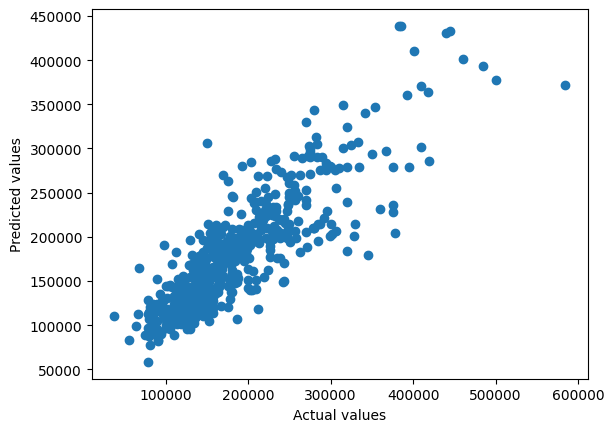

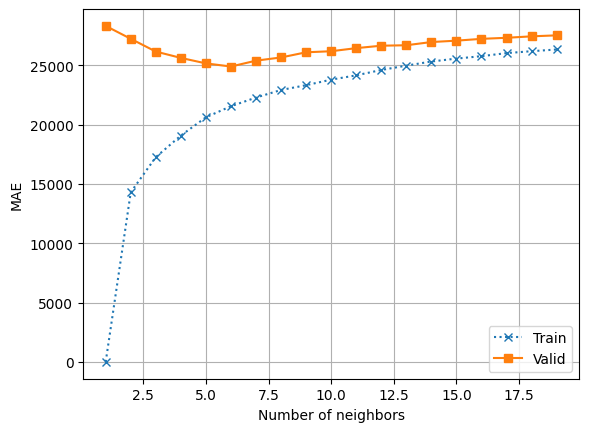

In [33]:
MAE_test_clean, score_clean, dataframe_diff = cv_knn(X_clean_train_v_80, X_clean_valid, X_clean_test, y_clean_train_v_80, y_clean_valid, y_clean_test, 20)

si esporta il dataframe per il confronto

In [34]:
print("Il miglior valore di k è: ", MAE_test_clean[0])
print("Errore: ", MAE_test_clean[1])
print("Score: ", score)

Il miglior valore di k è:  6
Errore:  26068.076222980657
Score:  0.661182123747055


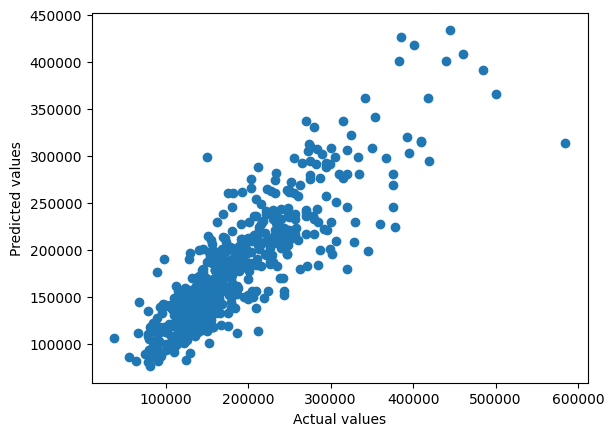

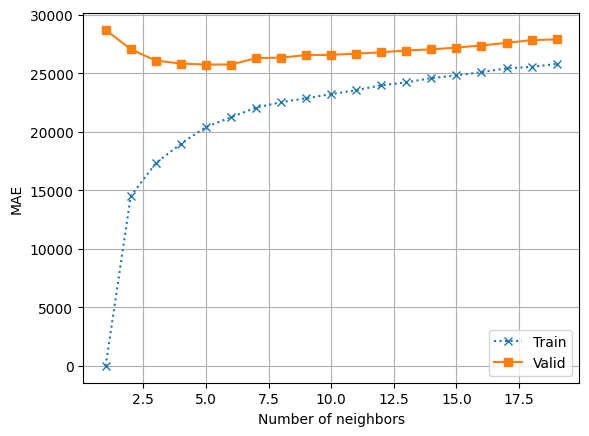

In [35]:
MAE_test_clean_wo_out, score_clean_wo_out, dataframe_confronto_KNN = cv_knn(X_clean_train_v_wo_out, X_clean_valid_wo_out, X_clean_test, y_clean_train_v_wo_out, y_clean_valid_wo_out, y_clean_test, 20)

In [36]:
dataframe_confronto_KNN = pd.concat([X_clean_test, dataframe_confronto_KNN], axis = 1)
dataframe_confronto_KNN.to_csv(r'df_confronto_KNN.csv', index = False)

In [37]:
print("Il miglior valore di k è: ", MAE_test_clean_wo_out[0])
print("Errore: ", MAE_test_clean_wo_out[1])
print("Score: ", score)

Il miglior valore di k è:  6
Errore:  25832.12827076223
Score:  0.661182123747055


<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

In questa fase si è fatto tuning sul parametro k ossia il numero di vicini per abbassare l'errore del modello.

Nel primo caso si sta prendendo in considerazione il dataset iniziale con gli outliers. Anche se in questo caso l'errore risulta essere minore rispetto a quando c'era k = 3, lo score si è leggermente abbassato. Questo vale anche per il caso dello stesso set di dati ma senza outliers. 


Per quanto riguarda il dataset pulito, si assiste ad un generale peggioramento delle prestazioni. 

Infine, analizzando i grafici dell'andamento del validation set e training set quest'ultimo assume in tutti e quattro i casi valori inferiori al primo arrivando ad avere prestazioni peggiori rispetto al modello base.

Per questo si prova a fare tuning unicamente sul training set.

In [38]:
def best_k_train(X_train, X_test, y_train, y_test, n_neighbors = 3):
    
    # Array per salvarsi i risultati ottenuti
    MAE = []
    MAE_plot = []
    
    # ------------------------------------------------------------------
    
    # Ciclo for per vedere i cambiamenti dell'mae in base al numero di vicini considerati
    for i in range(1, n_neighbors):
        
        # Creazione modello
        model =  KNeighborsRegressor(n_neighbors = i)
        model.fit(X_train, y_train)
        
        # Calcolo dell'errore (mae) sul training-set
        y_pred_train = model.predict(X_train)
        MAE_train = mean_absolute_error(y_true = y_train, y_pred = y_pred_train)
    
        # L'array mae contiene elementi che a loro volta sono array di 3 elementi: 
        # parametro di regolarizzazione, errore sul train 
        MAE_plot += [[i, MAE_train]]
        
    # ------------------------------------------------------------------
    
    # Si cerca l'errore migliore (il più piccolo)
    minimum_error = MAE_plot[0][1]
    best_n_neigh = MAE_plot[0][0]
    
    for i in range(len(MAE_plot)):
        if(minimum_error > MAE_plot[i][1]):
            minimum_error = MAE_plot[i][1]
            best_n_neigh = MAE_plot[i][0]

    # Si crea un nuovo modello con il parametro di regolarizzazione associato all'errore migliore
    best_model = KNeighborsRegressor(n_neighbors = best_n_neigh)
    best_model.fit(X_train, y_train)
    
    # Calcolo dell'errore assoluto sul test-set
    y_pred_test = best_model.predict(X_test)
    MAE_test = mean_absolute_error(y_true = y_test, y_pred = y_pred_test)
    
    # L'array best_n_estimators contiene elementi che a loro volta sono array di 2 elementi: 
    # numero di vicini, errore assoluto sul test
    MAE = [best_n_neigh, MAE_test]

    MAE_plot = np.array(MAE_plot)
    
    # Grafico y reali vs y predette
    plt.scatter(y_test, y_pred_test)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # Grafico
    fig, ax = plt.subplots()
    ax.plot(MAE_plot[:,0], MAE_plot[:,1], "x:", label = "Train")
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    ax.legend()
    ax.grid()
    
    # Calcolo dello score
    score = r2_score(y_test, y_pred_test)


    return MAE, score

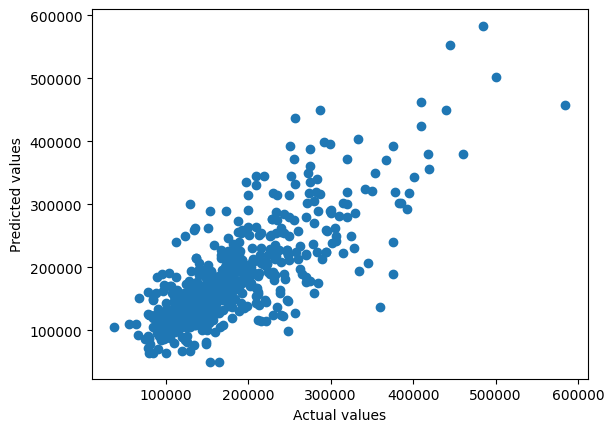

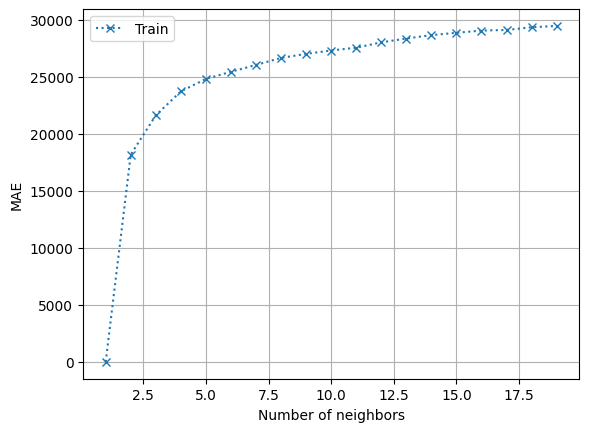

In [39]:
MAE_test_t, score_t= best_k_train(X_train_80, X_test, y_train_80, y_test, 20)

In [40]:
print("Il miglior valore di k è: ", MAE_test_t[0])
print("Errore: ", MAE_test_t[1])
print("Score: ", score_t)

Il miglior valore di k è:  1
Errore:  35078.66894197952
Score:  0.5627665332905945


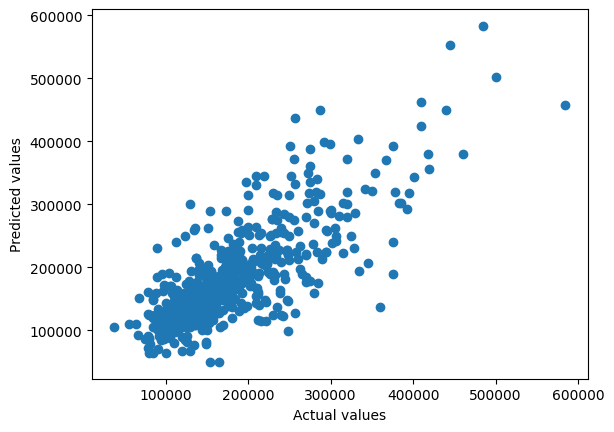

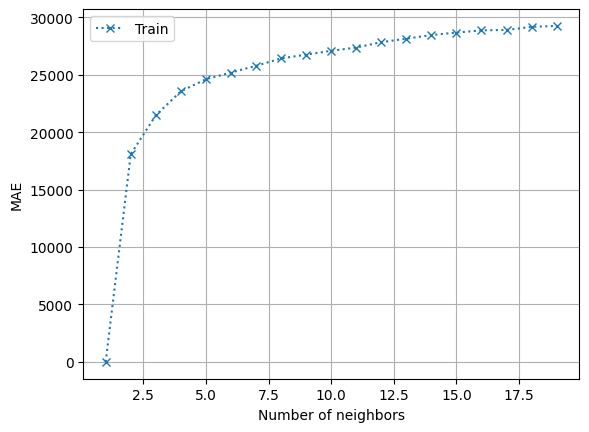

In [41]:
MAE_test_t_wo_out, score_t_wo_out = best_k_train(X_train_wo_out, X_test, y_train_wo_out, y_test, 20)

In [42]:
print("Il miglior valore di k è: ", MAE_test_t_wo_out[0])
print("Errore: ", MAE_test_t_wo_out[1])
print("Score: ", score_t_wo_out)

Il miglior valore di k è:  1
Errore:  35244.368600682596
Score:  0.5576480736852747


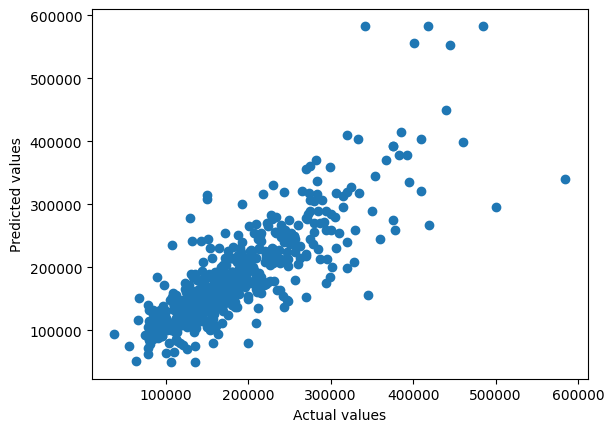

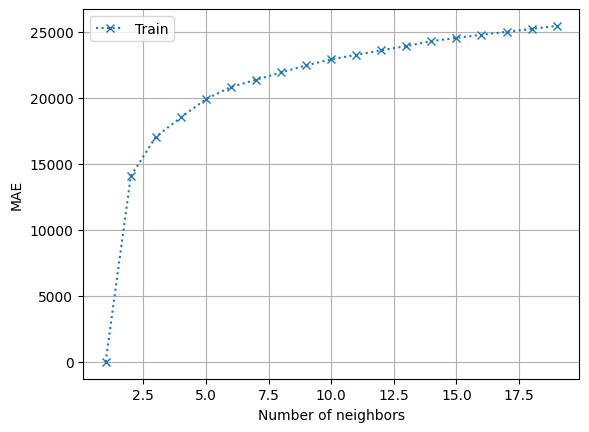

In [43]:
MAE_test_t_clean, score_t_clean = best_k_train(X_clean_train_80, X_clean_test, y_clean_train_80, y_clean_test, 20)

In [44]:
print("Il miglior valore di k è: ", MAE_test_t_clean[0])
print("Errore: ", MAE_test_t_clean[1])
print("Score: ", score_t_clean)

Il miglior valore di k è:  1
Errore:  28740.996587030717
Score:  0.654500157420765


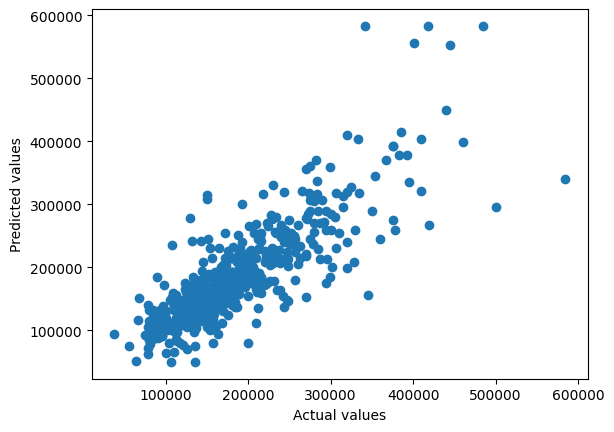

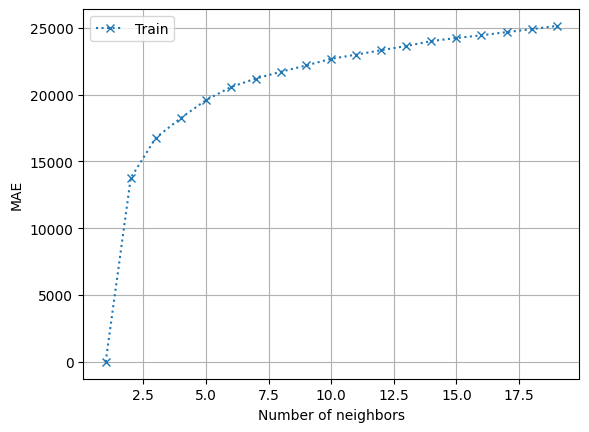

In [45]:
MAE_test_t_clean_wo_out, score_t_clean_wo_out = best_k_train(X_clean_train_wo_out, X_clean_test, y_clean_train_wo_out, y_clean_test, 20)

In [46]:
print("Il miglior valore di k è: ", MAE_test_t_clean_wo_out[0])
print("Errore: ", MAE_test_t_clean_wo_out[1])
print("Score: ", score_t_clean_wo_out)

Il miglior valore di k è:  1
Errore:  28616.423208191125
Score:  0.6562585858238725


<div class="alert alert-block alert-warning">
<b>Considerazioni</b>
</div>

La scelta di individuare l'errore minimo sul training set non ha portato ad alcun miglioramento rispetto alla tecnica del cross validation.

Si può osservare che in tutti i dataset il k migliore è pari a 1, ciò significa che la predizione si basa sulla singola istanza senza considerare alcun vicino. Nonostante questo si può dire che il dataset con le migliori prestazioni su questa funzione risulta essere il dataset pulito senza outliers.

Si vuole far notare nuovamente che la pulizia è stata efficace in questo processo, portando lo score dal 56% al 65%

<div class="alert alert-block alert-warning">
<b>Considerazioni finali</b>
</div>

Qui di seguito si presenta per ogni dataset la funzione che restituisce l'errore migliore:

+ Dataset sporco con outliers: Cross-Validation
+ Dataset sporco senza outliers: Cross-Validation
+ Dataset pulito con outliers: modello base
+ Dataset pulito senza outliers: modello base

Nel complessivo, come nei modelli precedenti si nota che il dataset che ritorna il risultato migliore è il dataset pulito con gli outliers sulla funzione base con l'errore pari a 30041.784414106944 e con uno score di 0.68591408915801. 

Questo dataset, tuttavia, ha una performance peggiore rispetto allo stesso senza gli oultliers sia sulla funzione in cui si utilizza il validation set per individuare il migliore valore di k, sia  sulla funzione in cui si utilizza il training set.

